## Catboost - Gemini ML Pipeline

In this notebook, I created a ML pipeline centered around the CatBoost ML model based on the features Gemini 2.5 Pro selected for me. This includes data filtering, cleaning, and mapping before eventually putting the data into the CatBoost classfier.

By: Numan Suri

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, roc_curve, auc, classification_report

We start off with loading the raw NHIS 2023 survey data and filtering it down only to the columns we need.

In [2]:
gemini_features = [
    "AGEP_A",          # age (years, 18‑85 top‑coded)
    "SEX_A",           # sex
    "HISPALLP_A",      # combined race / ethnicity
    "EDUCP_A",         # education level
    "BMICAT_A",        # BMI category
    "SMKCIGST_A",      # smoking status
    "HYPEV_A",         # ever hypertension
    "CHLEV_A",         # ever high cholesterol
    "DIBEV_A",         # ever diabetes
    "PHSTAT_A",        # self‑rated health
    "DEPEV_A",         # ever depression
    "COPDEV_A",        # ever COPD / chronic bronchitis / emphysema
    "STREV_A"          # ever stroke
]

target_columns = ['CHDEV_A', 'ANGEV_A', 'MIEV_A']

data_df = pd.read_csv('adult23.csv')
data_df = data_df[gemini_features + target_columns]

data_df

,AGEP_A,SEX_A,HISPALLP_A,EDUCP_A,BMICAT_A,SMKCIGST_A,HYPEV_A,CHLEV_A,DIBEV_A,PHSTAT_A,DEPEV_A,COPDEV_A,STREV_A,CHDEV_A,ANGEV_A,MIEV_A
0,67,1,3,1,3,4,1,1,2,5,1,2,1,2,2,2
1,73,1,2,8,3,1,1,2,1,3,2,2,2,1,2,1
2,48,1,3,5,4,4,2,2,2,1,2,2,2,2,2,2
3,42,2,2,9,3,3,2,2,2,1,2,2,2,2,2,2
4,50,2,2,7,2,4,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29517,77,2,2,5,4,3,1,1,2,3,1,1,2,2,2,2
29518,59,2,2,7,3,4,2,1,2,1,1,2,2,2,2,2
29519,66,1,2,8,4,4,2,2,2,3,2,2,2,2,2,2
29520,53,2,2,7,3,1,1,2,2,2,2,2,2,2,2,2


Now we are mapping the real values of the columns needed to their respective columns, as this will make the most accurate model when it comes to string recognition. Also, binary values are also being mapped to their respective string values as well.

In [3]:
def map_codes(col, mapping, unknown="Unknown"):
    """Map numeric codes to text; keep <NA>; anything else → 'Unknown'."""
    return (
        col.replace(mapping)          # map known codes
           .mask(col.isna(), pd.NA)   # preserve genuine <NA>
           .fillna(unknown)           # leftover unusual codes
           .astype("string")
    )

data_df["SEX_A"] = map_codes(data_df["SEX_A"], {1: "Male",  2: "Female"})

data_df["HISPALLP_A"] = map_codes(data_df["HISPALLP_A"],{
    1: "Hispanic", 2: "White‑NH", 3: "Black‑NH", 4: "Asian‑NH",
    5: "AIAN‑NH",  6: "AIAN+Other", 7: "Other"})

data_df["EDUCP_A"] = map_codes(data_df["EDUCP_A"], {
    0: "None/KG", 1: "1–11th", 2: "12th/no dip", 3: "GED",
    4: "HS Grad", 5: "Some College", 6: "Assoc‑Occ/Voc",
    7: "Assoc‑Acad", 8: "Bachelor", 9: "Master", 10: "Prof/PhD"})

data_df["BMICAT_A"] = map_codes(data_df["BMICAT_A"], {
    1: "Under", 2: "Normal", 3: "Over", 4: "Obese", 5: "ExtObese"})

data_df["SMKCIGST_A"] = map_codes(data_df["SMKCIGST_A"], {
    1: "Every day", 2: "Some days", 3: "Former", 4: "Never"})

data_df["PHSTAT_A"] = map_codes(data_df["PHSTAT_A"], {
    1: "Excellent", 2: "Very good", 3: "Good", 4: "Fair", 5: "Poor"})

binary_variables = ["HYPEV_A", "CHLEV_A", "DIBEV_A", "DEPEV_A", "COPDEV_A", "STREV_A"]

for col in binary_variables:
    data_df[col] = map_codes(data_df[col], {1: "Yes", 2: "No"})

Now we can create the binary composit target variabel called "heart disease", where we label a row as **1** if *any* of `CHDEV_A`, `ANGEV_A`, or `MIEV_A` equals 1 (history of CHD, angina, or MI); else 0.

Additionally, this is also where the X and y split happens. We have to drop the target variable itself AND the columns that made up that target variable to stop data leakage when defining X. 

When it comes to what is categorical or not, we stuck with a fairly straightforward definition, everything is categorical (thanks to the mapping we did above), except age, as that is a real number.

In [4]:
data_df["heart_disease"] = (
    (data_df["CHDEV_A"] == 1) | 
    (data_df["ANGEV_A"] == 1) | 
    (data_df["MIEV_A"] == 1)
).astype(int)

X = data_df.drop(columns=["heart_disease"] + target_columns)
y = data_df["heart_disease"]

# Defining the categorical and numerical columns (just age in this case)
cat_cols = X.columns.tolist()           
cat_cols.remove("AGEP_A")

Now, to get the machine learning portion of this set up, every column in cat_cols is first recast to Pandas’ string dtype and any gaps are filled with the sentinel "__MISSING__", allowing CatBoost to treat “missing” as just another category instead of discarding or incorrectly imputing those rows. This is wholly unique to the CatBoost model.

The data is then split 80 / 20—stratified on the heart‑disease label to preserve class balance. A CatBoostClassifier is wrapped in GridSearchCV, which explores 27 combinations of tree depth, learning rate, iteration count, and L2 regularisation, scoring each with 5‑fold cross‑validated F1 in parallel. 

Finally, calling grid_cb.fit() launches that search while explicitly flagging the categorical columns via cat_features, so CatBoost can leverage its native categorical encoding throughout training.

In [5]:
X[cat_cols] = X[cat_cols].astype("string").fillna("__MISSING__")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

cb = CatBoostClassifier(
    loss_function="Logloss",
    random_seed=42,
    verbose=0
)

param_grid_cb = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [200],
    'l2_leaf_reg': [3, 5, 7]
}

grid_cb = GridSearchCV(
    estimator=cb,
    param_grid=param_grid_cb,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_cb.fit(
    X_train,
    y_train,
    cat_features=cat_cols
)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.01; total time=   7.9s
[CV] END depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.01; total time=   8.1s
[CV] END depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.01; total time=   8.1s
[CV] END depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.01; total time=   8.4s
[CV] END depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.01; total time=   8.5s
[CV] END depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.05; total time=   8.6s
[CV] END depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.05; total time=   8.7s
[CV] END depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.05; total time=   8.9s
[CV] END depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.05; total time=   9.0s
[CV] END depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.05; total time=   9.1s
[CV] END depth=4, iterations=200, l2_leaf_reg=5, learning_

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x140c68450>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 8], 'iterations': [200],
                         'l2_leaf_reg': [3, 5, 7],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='f1', verbose=2)

In [6]:
best_cb = grid_cb.best_estimator_
print("Best CatBoost params:", grid_cb.best_params_)

Best CatBoost params: {'depth': 8, 'iterations': 200, 'l2_leaf_reg': 3, 'learning_rate': 0.1}


In [7]:
y_pred = best_cb.predict(X_test)
print("Test F1:", f1_score(y_test, y_pred))

Test F1: 0.18729096989966554


With the model created, now we can visualize the performance. We are focusing on the confusion matrix, ROC curve, and a bar chart comparing side by side precision, recall, and f1 scores.

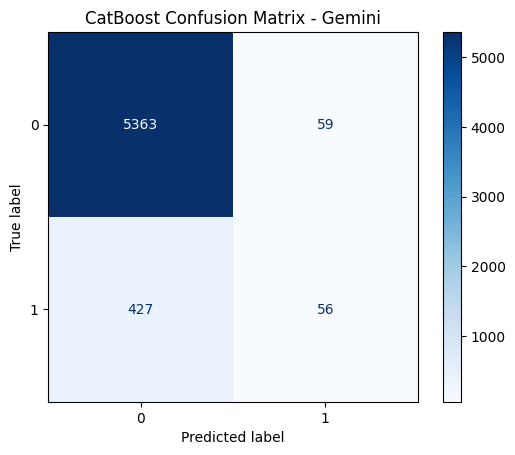

In [8]:
disp = ConfusionMatrixDisplay.from_estimator(
    best_cb, X_test, y_test, cmap=plt.cm.Blues
)
disp.ax_.set_title('CatBoost Confusion Matrix - Gemini')
plt.show()

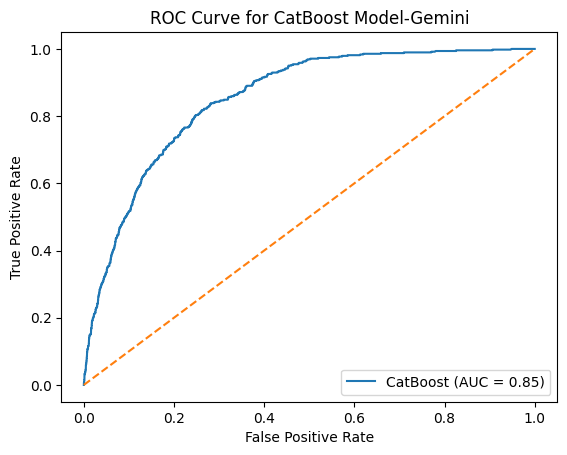

In [9]:
probs = best_cb.predict_proba(X_test)[:, 1]

# compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

# plot
plt.figure()
plt.plot(fpr, tpr, label=f'CatBoost (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CatBoost Model-Gemini')
plt.legend(loc='lower right')
plt.show()

<Figure size 640x480 with 0 Axes>

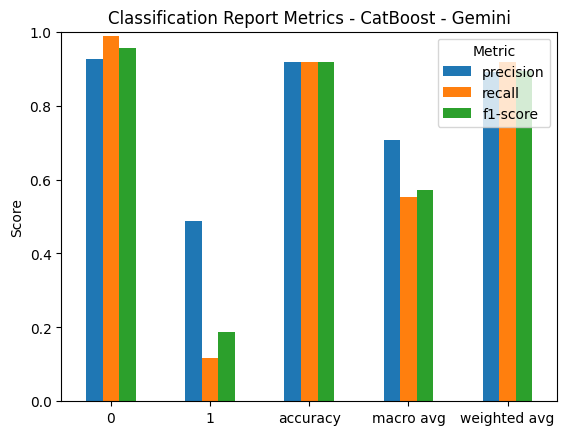

In [ ]:
y_pred = best_cb.predict(X_test)

# Generating classification report as a dict
report = classification_report(y_test, y_pred, output_dict=True)

# Convering to DataFrame and transposing so metrics are columns
df_report = pd.DataFrame(report).T

df_metrics = df_report[['precision', 'recall', 'f1-score']]

# Plot
plt.figure()
df_metrics.plot(kind='bar')
plt.title('Classification Report Metrics - CatBoost - Gemini')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title='Metric')
plt.show()

In [13]:
report_df = pd.DataFrame(report).T
report_df

,precision,recall,f1-score,support
0,0.926252,0.989118,0.956654,5422.000000
1,0.486957,0.115942,0.187291,483.000000
accuracy,0.917697,0.917697,0.917697,0.917697
macro avg,0.706604,0.552530,0.571972,5905.000000
weighted avg,0.890320,0.917697,0.893724,5905.000000
